# Lec 16: Boostrap Coding Portion
## CMSE 381 - Fall 2023
## Oct 11, 2023

In this lab, we are going to follow along with the book to generate boostrap samples. 

While `sklearn` does have a method called [`Bootstrap`](https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/modules/generated/sklearn.cross_validation.Bootstrap.html), it doesn't quite do what we want in terms of the example from class.  So instead, we're going to use even simpler functions. 

In [2]:
!pip install seaborn

     -------------------------------------- 294.6/294.6 kB 6.0 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
# Everyone's favorite standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 0. Generating data sets 

Below is some code that generates the data sets as described in Ch 5.2. Specifically, we wish to invest a fixed sum of money in two financial assets that yield returns of $X$ and $Y$, respectively, where $X$ and $Y$ are random quantities. 

We will invest a fraction $\alpha$ of our money in $X$, and will invest the remaining $(1-\alpha)$ in $Y$.

In [23]:
# Note that every time you rerun this function, you will get a new random sample.
def generatePortfolio(varX = 1, varY = 1.25,varXY = 0.5, seed = None):
    cov = np.array(((varX, varXY), (varXY, varY)))

    mean = (0,0)
    
    # This sets the seed if we don't want to generate a new data set each time
    np.random.seed(seed)
    
    # This generates our random data
    portfolio = np.random.multivariate_normal(mean, cov, (100))
    
    portfolio = pd.DataFrame(portfolio, columns = ['X', 'Y'])
    return portfolio

portfolio = generatePortfolio(seed = 42)
portfolio.head()


,X,Y
0,-0.306423,-0.567876
1,-1.447803,0.077964
2,0.328652,0.123879
3,-1.717033,-1.225487
4,0.036144,0.734641


Text(0, 0.5, 'Y')

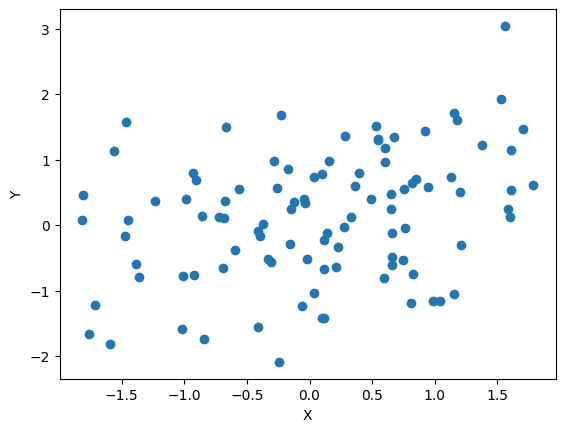

In [24]:
plt.scatter(portfolio.X, portfolio.Y)
plt.xlabel('X')
plt.ylabel('Y')

If I want to see how much money I'd make in each case based on a fixed alpha, I can color the points by the amount of income I would get if that pair of $X$ $Y$ values occured. 

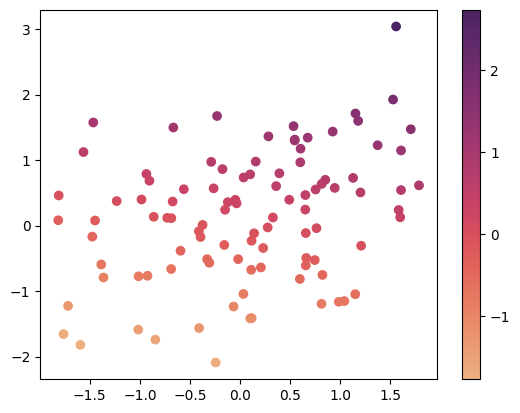

In [21]:
alpha = 0.2 #<----- Messing with this number, changes what percentage I invest
            #       in each company. 

income = portfolio.X*alpha + (1-alpha)*portfolio.Y

plt.scatter(portfolio.X, portfolio.Y, c = income, cmap = 'flare')
plt.colorbar()

**<font color=red>Warning:</font>**  I'm following the book in that they call the second column $Y$, but we're not doing a variable prediction with this data set. We just happen to have  labeled the outputs of our two companies $X$ and $Y$. 

# 1. Approximate $\hat \alpha$ with simulated data

We're assuming we're investing $\alpha$ percent of our money in stock $X$ and $(1-\alpha)$ percent of our money in stock $Y$. Our goal is to minimize the variance 
$$ \mathrm{Var}(\alpha X + (1-\alpha)Y)$$

In your homework, you will show that the variance is minimized when 
$$
\alpha = \frac{\sigma_Y^2 - \sigma_{XY}}{\sigma_X^2 + \sigma_Y^2 - 2\sigma_{XY}}
$$

&#9989; **<font color=red>Do this:</font>** First, based on the parameters we used to simulate our data, determine the true value of $\alpha$. *(Hint: You know what the answer should be from the slides, so make sure you can calculate it based on our inputs)*

In [ ]:
# Your code here

Next, we will figure out how to approximate $\alpha$ using the computed covariance from our particular data set. We can find the values for variance and covariance for our simulated data in pandas' covariance matrix. 

In [9]:
cov = portfolio.cov()



0.29514327159096254

&#9989; **<font color=red>Do this:</font>** Edit the function `alpha_hat` below which takes in a data frame and returns the predicted $\hat \alpha$ using the equation above. Use your function on the entire data set to get an estimate $\hat \alpha$.

In [46]:
def alpha_hat(df):

    cov = df.cov()
    return (cov.loc['Y', 'Y']**2-cov.loc['X', 'Y'])/(cov.loc['X','X']**2+cov.loc['Y','Y']**2-2*cov.loc['X','Y'])
    

alpha_hat(portfolio)

0.7068823045332099

Now, if your `alpha_hat` code is working, the following loop will generate 1000 data sets, calculate $\hat \alpha$ for each, and draw a histogram of the result. 

Mean: 1.3
StDev: 0.49


(array([  7.,  69., 251., 320., 217.,  94.,  33.,   4.,   4.,   1.]),
 array([-0.11563161,  0.27466117,  0.66495395,  1.05524673,  1.44553951,
         1.8358323 ,  2.22612508,  2.61641786,  3.00671064,  3.39700342,
         3.7872962 ]),
 <BarContainer object of 10 artists>)

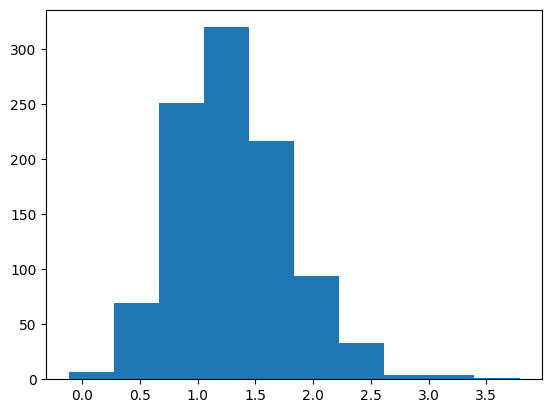

In [26]:
allAlphas = [] 
for i in range (1000):
    
    # Resimualte a new portfolio data set. Because I'm not passing 
    # in a seed, I get a new portfolio data set every time. 
    portfolio = generatePortfolio()
    
    # Compute the alpha_hat and append it to my list
    allAlphas.append(alpha_hat(portfolio))
    
print('Mean:', round(np.mean(allAlphas),2))
print('StDev:', round(np.std(allAlphas),2))

    
plt.hist(allAlphas)


![Stop Icon](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1e/Vienna_Convention_road_sign_B2a.svg/180px-Vienna_Convention_road_sign_B2a.svg.png)

Great, you got to here! Hang out for a bit, there's more lecture before we go on to the next portion. 

# 2. Resampling data 

Ok, so normally we don't have access to those original parameters to figure out what $\alpha$ actually should be, nor do we have the ability to simulate data for ourselves. So, the answer is the boostrap!

First, we get our data set. **<font color=red>Note</font>**: For the rest of this exercise, I pretend that I am not allowed to simulate anything. I was just handed this data set and it's all I get to work with. 

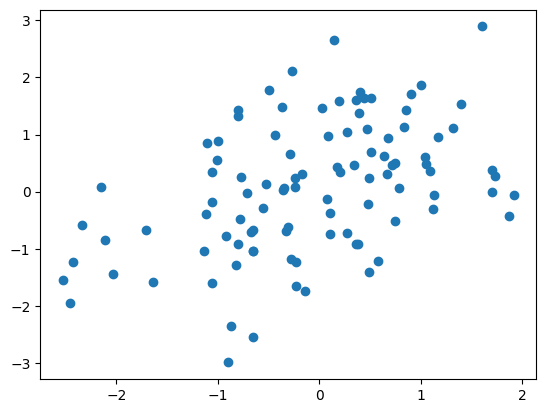

In [27]:
portfolio = generatePortfolio(seed = 0)
plt.scatter(portfolio.X, portfolio.Y)

The main thing we need to do is to sample our data set with replacement, which we can do with the `sample` function built into the data frame. In this function, `frac=1` means that we use 100% of our data (so we end up with $n$ samples from our original $n$ data points), and `replace=True` means we get to pick points with replacement 

In [47]:
samp_port = portfolio.sample(frac=1,replace=True)

print('Notice that the `samp_port` dataframe has 100 rows.')
print('Length of samp_port:', len(samp_port.index))

print('\nbut if we get rid of duplicates we have less \nthan 100 data points represented.')
print('Length of samp_port without duplicates:', len(set(samp_port.index)))
samp_port.head()

Notice that the `samp_port` dataframe has 100 rows.
Length of samp_port: 100

but if we get rid of duplicates we have less 
than 100 data points represented.
Length of samp_port without duplicates: 66


,X,Y
37,0.104313,-0.735221
60,0.379884,-0.908269
0,-1.636697,-1.588562
83,1.739046,0.267471
82,0.446264,1.642811


&#9989; **<font color=red>Do this:</font>** Repeat the following procedure 1000 times:
- Generate a new sample of your `portfolio` data set (Note: DO NOT resimulate your portfolio data set)
- Use your `alpha_hat` function from above to compute $\hat \alpha$ and keep it in your list

Then, draw a histogram of the results. 

[0.7504939132134579, 0.6958921553759063, 0.6082037147653991, 0.6654904614160257, 0.7021698421399324, 0.8175729020818077, 0.7565944290477821, 0.6951972888861963, 0.7895830248007623, 0.8657134258096141]


(array([  7.,  18.,  57.,  92., 176., 212., 207., 160.,  59.,  12.]),
 array([0.2658816 , 0.34210979, 0.41833798, 0.49456617, 0.57079435,
        0.64702254, 0.72325073, 0.79947892, 0.87570711, 0.9519353 ,
        1.02816349]),
 <BarContainer object of 10 artists>)

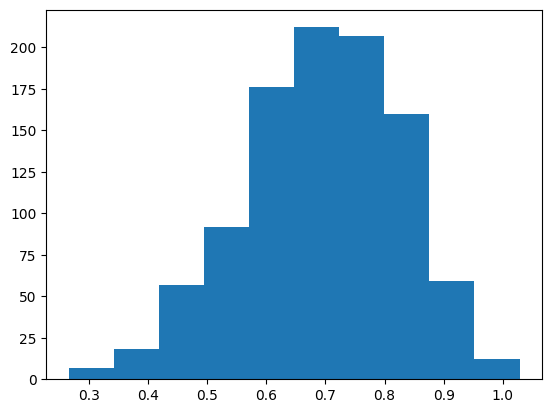

In [49]:
alphahats = []
B = 1000 #<---- maybe set this to 10 or so while you're debugging

for i in range(B):
    
    sample = portfolio.sample(frac=1,replace=True)
    alphahats.append(alpha_hat(sample))

    pass

# a printout for debugging
print(alphahats[:10])

plt.hist(alphahats)

The last thing to do is determine the error estimate. Eqn 5.8 in the book says that we can estimate the error using 
$$
SE_B(\hat \alpha) = \sqrt{ \frac{1}{B-1}
	\sum_{r=1}^B \left(
	\hat \alpha^{*r} - \frac{1}{B}\sum_{r'=1}^B \hat \alpha^{*r'}
	\right)^2
	}
    $$
where $\hat \alpha^{*i}$ is the $i$th prediction (AKA the $i$th entry in your `alphahats` list up there). 

&#9989; **<font color=red>Do this:</font>** Use your `alphahats` list  to determine the standard error of $\hat \alpha$. 

In [ ]:
# Your code here






-----
### Congratulations, we're done!
Written by Dr. Liz Munch, Michigan State University

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.